##### Author: Matthew W. Boyce, PhD, 
##### Email: boyce.matthew@epa.gov

##### Version: 1.0 06-17-2021

##### Description:  
- This script compares the Global performance of the aggregate data DataFrame generated by the ReadAndProcessData notebook. For this comparison, the notebook will examine the general landscdape of predictions for each metabolite, measure the similairty between prediction software (using Jaccard distance and Coverage), then compare overal performance (Sensitivity and Precision) by comparing findings to literature.

##### Notes: 
- This script uses standard libraries os, pandas, numpy, matplotlib, rdkit, scipy, and a script of custom functions named model_comp
- This script pulls the aggregate data and processed DSSTox data from the root/data/processed folder

##### Potential issues: *None known*



#### Updates:
- Revisions made by Grace Patlewicz, Senior PI in response to reviewer comments.
- Version 2: 3-Dec-2021

In [1]:
import numpy as np
import os as os
import pandas as pd
import seaborn as sns

from rdkit import Chem

from IPython.core.display import HTML

import scipy.cluster.hierarchy as hc
from scipy.spatial.distance import pdist, squareform, cdist

In [2]:
TOP = os.getcwd().replace('notebooks', '')

In [3]:
raw_dat_dir = TOP + 'data/raw/'
processed_dat_dir = TOP + 'data/processed/'
interim_dat_dir = TOP + 'data/interim/'
figures_dir = TOP + 'reports/figures/'
external_dir = TOP + 'data/external/'

In [4]:
import sys

sys.path.append(TOP + 'src/data/')

from model_comp import *

In [5]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

## Global comparison of model performance using Sensitivity and Precision

In [6]:
agg_Data = pd.read_csv(processed_dat_dir+'Cleaned_AggregateData_031221_sorted.csv')
DSSToxList = pd.read_csv(processed_dat_dir+ 'Processed_CompToxList_v1.csv')

In [88]:
agg_Data.shape

(9539, 14)

In [17]:
modelList = ['TB_ivt', 'TB_iv','Meteor','BioTransformer','TIMES_InVivo','TIMES_InVitro', 'SyGMa', 'CTS', 'Reported'] 

## Prediction Counts Per Model and Parent <a class="anchor" id="second-bullet"></a>

In [18]:
# Model comparison for each parent compound

#Generate new dataframe to make comparison and assign DTXSIDs based on csv output from CompTox and takes the sum of metabolites generates
#for each DTXSID

metab_Compare = pd.DataFrame(data = None, columns = ['DTXSID','Metab_Count']+ modelList)
metab_Compare['DTXSID'] = DSSToxList['INPUT']
metab_Compare['Metab_Count'] = [agg_Data[agg_Data['DTXSID']==x].shape[0] for x in metab_Compare['DTXSID']]

#Returns the number of metabolites predicted by each software for each parent DTXSID
for model in modelList:
    metab_Compare[model] = [agg_Data[(agg_Data['DTXSID']==DTXSID)&(agg_Data[model]==1)].shape[0] for DTXSID in metab_Compare['DTXSID']]
    
metab_Compare

,DTXSID,Metab_Count,TB_ivt,TB_iv,Meteor,BioTransformer,TIMES_InVivo,TIMES_InVitro,SyGMa,CTS,Reported
0,DTXSID0044151,87,4,1,4,31,4,9,80,5,0
1,DTXSID6025725,463,5,3,7,370,7,11,132,15,7
2,DTXSID8031077,532,6,9,17,0,32,12,493,21,13
3,DTXSID1025726,182,5,3,4,55,7,9,148,18,8
4,DTXSID4025791,158,3,11,7,44,28,3,130,6,0
5,DTXSID5023792,96,3,10,8,34,24,3,67,6,4
6,DTXSID8020961,124,3,1,7,52,4,10,91,16,6
7,DTXSID9020827,121,9,9,7,75,16,9,58,7,5
8,DTXSID0020151,178,4,4,5,59,7,4,132,9,9
9,DTXSID1020069,955,4,4,12,283,11,6,661,9,6


In [29]:
metab_Compare.head()

,DTXSID,Metab_Count,TB_ivt,TB_iv,Meteor,BioTransformer,TIMES_InVivo,TIMES_InVitro,SyGMa,CTS,Reported
0,DTXSID0044151,87,4,1,4,31,4,9,80,5,0
1,DTXSID6025725,463,5,3,7,370,7,11,132,15,7
2,DTXSID8031077,532,6,9,17,0,32,12,493,21,13
3,DTXSID1025726,182,5,3,4,55,7,9,148,18,8
4,DTXSID4025791,158,3,11,7,44,28,3,130,6,0


Which substances did Biotransformer not make a prediction for?

In [23]:
metab_Compare[metab_Compare['BioTransformer'] ==0]['DTXSID'].tolist()

,DTXSID,Metab_Count,TB_ivt,TB_iv,Meteor,BioTransformer,TIMES_InVivo,TIMES_InVitro,SyGMa,CTS,Reported
2,DTXSID8031077,532,6,9,17,0,32,12,493,21,13
16,DTXSID7020685,38,2,7,2,0,9,2,12,0,15
17,DTXSID9020376,919,2,5,382,0,8,4,0,0,543
18,DTXSID9020453,28,1,1,1,0,4,3,2,19,6
21,DTXSID4023624,201,6,17,8,0,51,8,160,7,6
25,DTXSID9047251,832,9,8,23,0,22,15,739,55,37
35,DTXSID7020762,34,1,7,11,0,12,1,19,7,2
36,DTXSID8021482,53,1,7,32,0,11,1,34,9,4


In [27]:
BT_zero = DSSToxList[DSSToxList['DTXSID'].isin(metab_Compare[metab_Compare['BioTransformer'] ==0]['DTXSID'].tolist())]

In [54]:
BT_zero

,Unnamed: 0,INPUT,FOUND_BY,DTXSID,PREFERRED_NAME,CASRN,Parent_INCHIKEY,SMILES,QSAR_READY_SMILES,QSAR_READY_INCHIKEY
2,2,DTXSID8031077,DSSTox_Substance_Id,DTXSID8031077,Curcumin,458-37-7,VFLDPWHFBUODDF-FCXRPNKRSA-N,COC1=CC(\C=C\C(=O)CC(=O)\C=C\C2=CC=C(O)C(OC)=C...,COC1=CC(C=CC(=O)CC(=O)C=CC2=CC(OC)=C(O)C=C2)=C...,VFLDPWHFBUODDF-UHFFFAOYSA-N
16,16,DTXSID7020685,DSSTox_Substance_Id,DTXSID7020685,beta-Hexachlorocyclohexane,319-85-7,JLYXXMFPNIAWKQ-CDRYSYESSA-N,Cl[C@H]1[C@H](Cl)[C@@H](Cl)[C@H](Cl)[C@@H](Cl)...,ClC1C(Cl)C(Cl)C(Cl)C(Cl)C1Cl,JLYXXMFPNIAWKQ-UHFFFAOYSA-N
17,17,DTXSID9020376,DSSTox_Substance_Id,DTXSID9020376,"1,1'-Oxybis[2,3,4,5,6-pentabromobenzene]",1163-19-5,WHHGLZMJPXIBIX-UHFFFAOYSA-N,BrC1=C(Br)C(Br)=C(OC2=C(Br)C(Br)=C(Br)C(Br)=C2...,BrC1=C(Br)C(Br)=C(OC2=C(Br)C(Br)=C(Br)C(Br)=C2...,WHHGLZMJPXIBIX-UHFFFAOYSA-N
18,18,DTXSID9020453,DSSTox_Substance_Id,DTXSID9020453,Dieldrin,60-57-1,DFBKLUNHFCTMDC-PICURKEMSA-N,ClC1=C(Cl)[C@]2(Cl)[C@@H]3[C@@H]4C[C@@H]([C@H]...,ClC1=C(Cl)C2(Cl)C3C4CC(C5OC45)C3C1(Cl)C2(Cl)Cl,DFBKLUNHFCTMDC-UHFFFAOYSA-N
21,21,DTXSID4023624,DSSTox_Substance_Id,DTXSID4023624,Sulindac,38194-50-2,MLKXDPUZXIRXEP-MFOYZWKCSA-N,CC1=C(CC(O)=O)C2=C(C=CC(F)=C2)\C1=C/C1=CC=C(C=...,CC1=C(CC(O)=O)C2=CC(F)=CC=C2C1=CC1=CC=C(C=C1)S...,MLKXDPUZXIRXEP-UHFFFAOYSA-N
25,25,DTXSID9047251,DSSTox_Substance_Id,DTXSID9047251,CP-122721,145742-28-5,ZIWFCOIGUNPHPM-HKUYNNGSSA-N,COC1=C(CN[C@H]2CCCN[C@H]2C2=CC=CC=C2)C=C(OC(F)...,COC1=C(CNC2CCCNC2C2=CC=CC=C2)C=C(OC(F)(F)F)C=C1,ZIWFCOIGUNPHPM-UHFFFAOYSA-N
35,35,DTXSID7020762,DSSTox_Substance_Id,DTXSID7020762,Isopropanol,67-63-0,KFZMGEQAYNKOFK-UHFFFAOYSA-N,CC(C)O,CC(C)O,KFZMGEQAYNKOFK-UHFFFAOYSA-N
36,36,DTXSID8021482,DSSTox_Substance_Id,DTXSID8021482,Acetone,67-64-1,CSCPPACGZOOCGX-UHFFFAOYSA-N,CC(C)=O,CC(C)=O,CSCPPACGZOOCGX-UHFFFAOYSA-N


In [32]:
BT_zero_dict = {k:Chem.MolFromSmiles(v) for k,v in zip(BT_zero['DTXSID'], BT_zero['SMILES'])}

In [33]:
BT_zero_dict

{'DTXSID8031077': <rdkit.Chem.rdchem.Mol at 0x7f39f2fca3a0>,
 'DTXSID7020685': <rdkit.Chem.rdchem.Mol at 0x7f39f271fee0>,
 'DTXSID9020376': <rdkit.Chem.rdchem.Mol at 0x7f39fa7c8990>,
 'DTXSID9020453': <rdkit.Chem.rdchem.Mol at 0x7f39fa7c8170>,
 'DTXSID4023624': <rdkit.Chem.rdchem.Mol at 0x7f39fa9346c0>,
 'DTXSID9047251': <rdkit.Chem.rdchem.Mol at 0x7f39fa971760>,
 'DTXSID7020762': <rdkit.Chem.rdchem.Mol at 0x7f39fa971c60>,
 'DTXSID8021482': <rdkit.Chem.rdchem.Mol at 0x7f39f2765cb0>}

In [35]:
from rdkit.Chem import Descriptors

In [36]:
{k:Descriptors.MolLogP(v) for k,v in BT_zero_dict.items()}

{'DTXSID8031077': 3.3699000000000026,
 'DTXSID7020685': 3.644400000000001,
 'DTXSID9020376': 11.1039,
 'DTXSID9020453': 4.481400000000002,
 'DTXSID4023624': 4.3655000000000035,
 'DTXSID9047251': 4.176700000000003,
 'DTXSID7020762': 0.38710000000000006,
 'DTXSID8021482': 0.5952999999999999}

In [37]:
{k:Descriptors.MolWt(v) for k,v in BT_zero_dict.items()}

{'DTXSID8031077': 368.3850000000001,
 'DTXSID7020685': 290.832,
 'DTXSID9020376': 959.171,
 'DTXSID9020453': 380.913,
 'DTXSID4023624': 356.41800000000006,
 'DTXSID9047251': 380.4100000000001,
 'DTXSID7020762': 60.096000000000004,
 'DTXSID8021482': 58.080000000000005}

In [38]:
DSSToxList[DSSToxList['DTXSID']== 'DTXSID9020376']

,Unnamed: 0,INPUT,FOUND_BY,DTXSID,PREFERRED_NAME,CASRN,Parent_INCHIKEY,SMILES,QSAR_READY_SMILES,QSAR_READY_INCHIKEY
17,17,DTXSID9020376,DSSTox_Substance_Id,DTXSID9020376,"1,1'-Oxybis[2,3,4,5,6-pentabromobenzene]",1163-19-5,WHHGLZMJPXIBIX-UHFFFAOYSA-N,BrC1=C(Br)C(Br)=C(OC2=C(Br)C(Br)=C(Br)C(Br)=C2...,BrC1=C(Br)C(Br)=C(OC2=C(Br)C(Br)=C(Br)C(Br)=C2...,WHHGLZMJPXIBIX-UHFFFAOYSA-N


In [41]:
DSSToxList_dict = {k:Chem.MolFromSmiles(v) for k,v in zip(DSSToxList['DTXSID'], DSSToxList['SMILES'])}
{k:Descriptors.MolWt(v) for k,v in DSSToxList_dict.items()}

{'DTXSID0044151': 183.123,
 'DTXSID6025725': 138.12599999999998,
 'DTXSID8031077': 368.3850000000001,
 'DTXSID1025726': 138.126,
 'DTXSID4025791': 137.138,
 'DTXSID5023792': 137.138,
 'DTXSID8020961': 138.126,
 'DTXSID9020827': 345.6529999999999,
 'DTXSID0020151': 150.177,
 'DTXSID1020069': 225.295,
 'DTXSID3020205': 312.365,
 'DTXSID5020027': 71.07900000000001,
 'DTXSID5020152': 108.13999999999997,
 'DTXSID6020143': 122.12299999999996,
 'DTXSID6022345': 354.491,
 'DTXSID7020182': 228.291,
 'DTXSID7020685': 290.832,
 'DTXSID9020376': 959.171,
 'DTXSID9020453': 380.913,
 'DTXSID0022777': 381.3790000000001,
 'DTXSID4020371': 248.307,
 'DTXSID4023624': 356.41800000000006,
 'DTXSID4034150': 375.8710000000001,
 'DTXSID5025607': 178.231,
 'DTXSID9023752': 236.29600000000002,
 'DTXSID9047251': 380.4100000000001,
 'DTXSID0020529': 182.135,
 'DTXSID4020373': 320.04600000000005,
 'DTXSID4020375': 354.491,
 'DTXSID5020528': 182.135,
 'DTXSID8020913': 128.17399999999995,
 'DTXSID9020374': 318.0300

In [74]:
metab_Compare[metab_Compare['CTS'] == 0]

,DTXSID,Metab_Count,TB_ivt,TB_iv,Meteor,BioTransformer,TIMES_InVivo,TIMES_InVitro,SyGMa,CTS,Reported
16,DTXSID7020685,38,2,7,2,0,9,2,12,0,15
17,DTXSID9020376,919,2,5,382,0,8,4,0,0,543


In [45]:
metab_Compare[metab_Compare['TB_ivt'] == 0]

,DTXSID,Metab_Count,TB_ivt,TB_iv,Meteor,BioTransformer,TIMES_InVivo,TIMES_InVitro,SyGMa,CTS,Reported
13,DTXSID6020143,122,0,0,2,63,2,1,88,4,2


In [47]:
DSSToxList[DSSToxList['DTXSID'].isin([ 'DTXSID7020182','DTXSID9023752'])]

,Unnamed: 0,INPUT,FOUND_BY,DTXSID,PREFERRED_NAME,CASRN,Parent_INCHIKEY,SMILES,QSAR_READY_SMILES,QSAR_READY_INCHIKEY
15,15,DTXSID7020182,DSSTox_Substance_Id,DTXSID7020182,Bisphenol A,80-05-7,IISBACLAFKSPIT-UHFFFAOYSA-N,CC(C)(C1=CC=C(O)C=C1)C1=CC=C(O)C=C1,CC(C)(C1=CC=C(O)C=C1)C1=CC=C(O)C=C1,IISBACLAFKSPIT-UHFFFAOYSA-N
24,24,DTXSID9023752,DSSTox_Substance_Id,DTXSID9023752,Zileuton,111406-87-2,MWLSOWXNZPKENC-UHFFFAOYSA-N,CC(N(O)C(N)=O)C1=CC2=C(S1)C=CC=C2,CC(N(O)C(N)=O)C1=CC2=C(S1)C=CC=C2,MWLSOWXNZPKENC-UHFFFAOYSA-N


<AxesSubplot:>

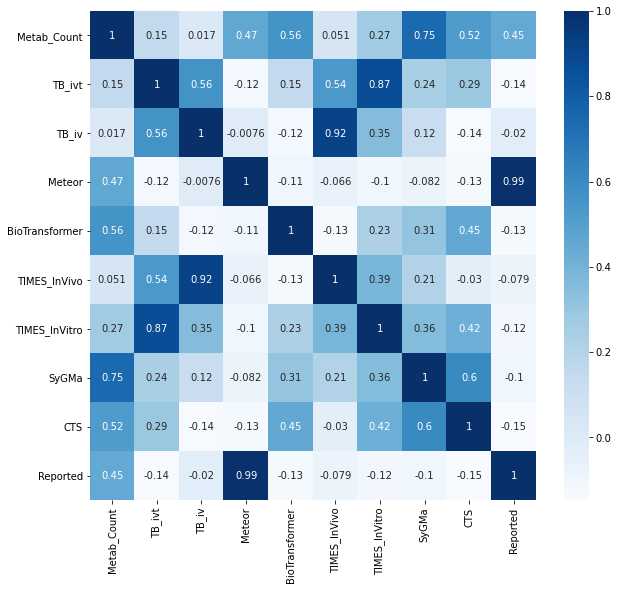

In [73]:
plt.figure(figsize = (10,9))
sns.heatmap(metab_Compare.corr(), cmap = 'Blues', annot = True)

In [51]:
metab_Compare[metab_Compare['TIMES_InVitro'] == 0]

,DTXSID,Metab_Count,TB_ivt,TB_iv,Meteor,BioTransformer,TIMES_InVivo,TIMES_InVitro,SyGMa,CTS,Reported


In [52]:
metab_Compare[metab_Compare['SyGMa'] == 0]

,DTXSID,Metab_Count,TB_ivt,TB_iv,Meteor,BioTransformer,TIMES_InVivo,TIMES_InVitro,SyGMa,CTS,Reported
17,DTXSID9020376,919,2,5,382,0,8,4,0,0,543


In [57]:
metab_Compare[(metab_Compare['BioTransformer'] >200 ) & (metab_Compare['SyGMa'] >200 )]

,DTXSID,Metab_Count,TB_ivt,TB_iv,Meteor,BioTransformer,TIMES_InVivo,TIMES_InVitro,SyGMa,CTS,Reported
9,DTXSID1020069,955,4,4,12,283,11,6,661,9,6
10,DTXSID3020205,568,9,15,21,285,22,10,341,12,11
22,DTXSID4034150,889,7,5,19,538,15,10,429,51,8


In [58]:
DSSToxList[DSSToxList['DTXSID'].isin(['DTXSID1020069', 'DTXSID3020205', 'DTXSID4034150'])]

,Unnamed: 0,INPUT,FOUND_BY,DTXSID,PREFERRED_NAME,CASRN,Parent_INCHIKEY,SMILES,QSAR_READY_SMILES,QSAR_READY_INCHIKEY
9,9,DTXSID1020069,DSSTox_Substance_Id,DTXSID1020069,2-Amino-5-azotoluene,97-56-3,PFRYFZZSECNQOL-UHFFFAOYSA-N,CC1=C(N)C=CC(=C1)N=NC1=C(C)C=CC=C1,CC1=C(N)C=CC(=C1)N=NC1=C(C)C=CC=C1,PFRYFZZSECNQOL-UHFFFAOYSA-N
10,10,DTXSID3020205,DSSTox_Substance_Id,DTXSID3020205,Benzyl butyl phthalate,85-68-7,IRIAEXORFWYRCZ-UHFFFAOYSA-N,CCCCOC(=O)C1=C(C=CC=C1)C(=O)OCC1=CC=CC=C1,CCCCOC(=O)C1=C(C=CC=C1)C(=O)OCC1=CC=CC=C1,IRIAEXORFWYRCZ-UHFFFAOYSA-N
22,22,DTXSID4034150,DSSTox_Substance_Id,DTXSID4034150,Haloperidol,52-86-8,LNEPOXFFQSENCJ-UHFFFAOYSA-N,OC1(CCN(CCCC(=O)C2=CC=C(F)C=C2)CC1)C1=CC=C(Cl)...,OC1(CCN(CCCC(=O)C2=CC=C(F)C=C2)CC1)C1=CC=C(Cl)...,LNEPOXFFQSENCJ-UHFFFAOYSA-N


In [59]:
metab_Compare[(metab_Compare['BioTransformer'] >200 ) | (metab_Compare['SyGMa'] >200 )]

,DTXSID,Metab_Count,TB_ivt,TB_iv,Meteor,BioTransformer,TIMES_InVivo,TIMES_InVitro,SyGMa,CTS,Reported
1,DTXSID6025725,463,5,3,7,370,7,11,132,15,7
2,DTXSID8031077,532,6,9,17,0,32,12,493,21,13
9,DTXSID1020069,955,4,4,12,283,11,6,661,9,6
10,DTXSID3020205,568,9,15,21,285,22,10,341,12,11
20,DTXSID4020371,435,1,1,6,362,6,7,105,15,8
22,DTXSID4034150,889,7,5,19,538,15,10,429,51,8
24,DTXSID9023752,421,9,0,12,345,3,12,59,37,2
25,DTXSID9047251,832,9,8,23,0,22,15,739,55,37


In [20]:
metab_Compare.to_csv(interim_dat_dir+'Metabolism_Comparison_031221.csv')

In [75]:
#uses the metab_Compare dataframe to generate a dataframe that summarized the percent of total metabolites generated by each software for each parent compound
metab_Compare_Percent = metab_Compare.copy()
for model in modelList:
    metab_Compare_Percent[model] = round([agg_Data[(agg_Data['DTXSID']==DTXSID)&(agg_Data[model]==1)].shape[0] 
                         for DTXSID in metab_Compare['DTXSID']]/metab_Compare['Metab_Count']*100,2)
    
metab_Compare_Percent

,DTXSID,Metab_Count,TB_ivt,TB_iv,Meteor,BioTransformer,TIMES_InVivo,TIMES_InVitro,SyGMa,CTS,Reported
0,DTXSID0044151,87,4.60,1.15,4.60,35.63,4.60,10.34,91.95,5.75,0.00
1,DTXSID6025725,463,1.08,0.65,1.51,79.91,1.51,2.38,28.51,3.24,1.51
2,DTXSID8031077,532,1.13,1.69,3.20,0.00,6.02,2.26,92.67,3.95,2.44
3,DTXSID1025726,182,2.75,1.65,2.20,30.22,3.85,4.95,81.32,9.89,4.40
4,DTXSID4025791,158,1.90,6.96,4.43,27.85,17.72,1.90,82.28,3.80,0.00
5,DTXSID5023792,96,3.12,10.42,8.33,35.42,25.00,3.12,69.79,6.25,4.17
6,DTXSID8020961,124,2.42,0.81,5.65,41.94,3.23,8.06,73.39,12.90,4.84
7,DTXSID9020827,121,7.44,7.44,5.79,61.98,13.22,7.44,47.93,5.79,4.13
8,DTXSID0020151,178,2.25,2.25,2.81,33.15,3.93,2.25,74.16,5.06,5.06
9,DTXSID1020069,955,0.42,0.42,1.26,29.63,1.15,0.63,69.21,0.94,0.63


<i>The below bargraphs are redundant with the ReadAndProcess bargraphs but retained for reference</i>

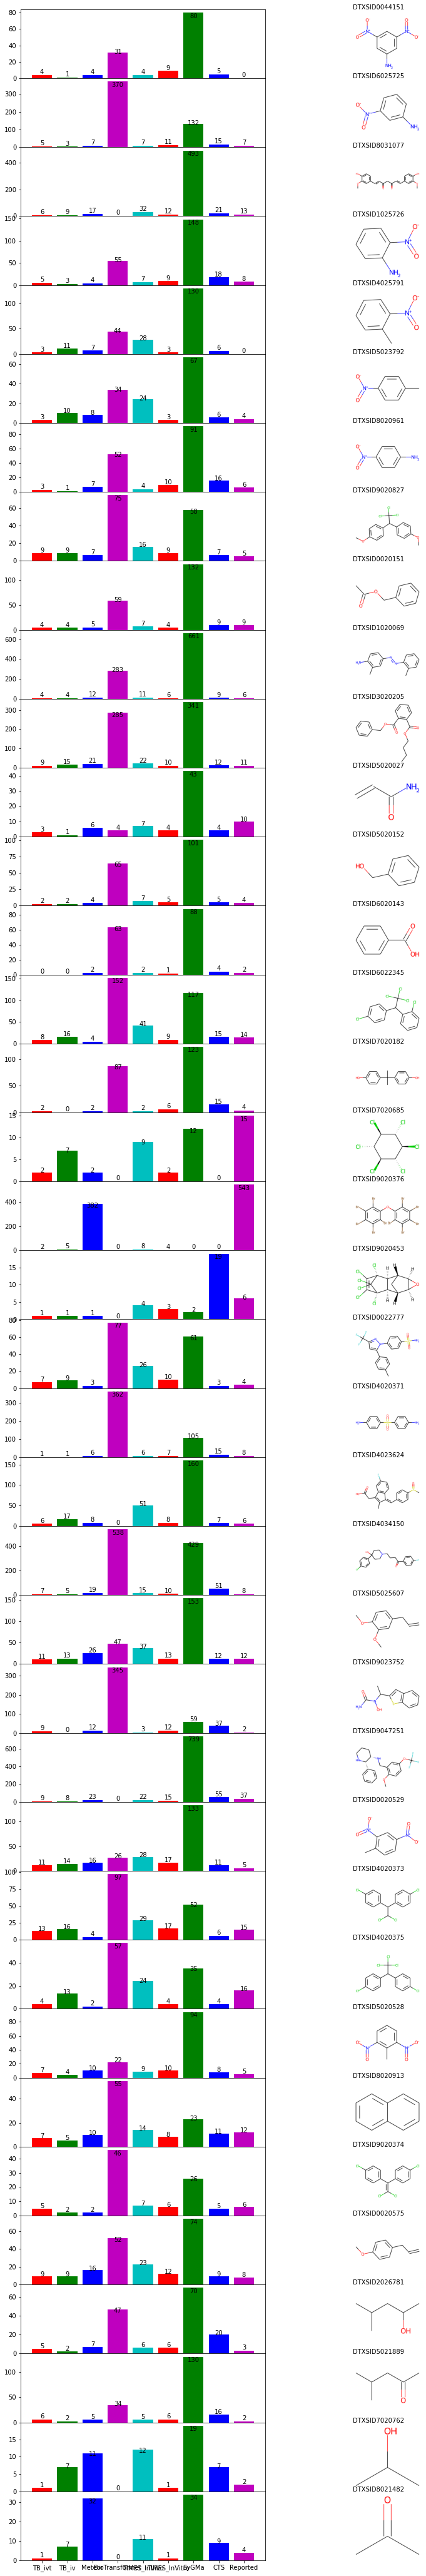

In [22]:
#Generates bargraphs for each parent compound that returns the total metabolites generated by each prediction software accompanied by
fig, axs = plt.subplots(metab_Compare.shape[0],2, gridspec_kw = {'hspace':0,'wspace':0},figsize = (14, 75))
colors = ['r','g','b','m','c']
image_List = [Chem.Draw.MolToImage(Chem.MolFromSmiles(x)) for x in DSSToxList['SMILES']]
for x in range(metab_Compare.shape[0]):
    rect1 =  axs[x,0].bar(modelList, metab_Compare.loc[x, modelList], color = colors)
    autolabel(rect1, axs[x,0])
    axs[x,1].imshow(image_List[x])
    axs[x,1].axis('off')
    axs[x,1].annotate(metab_Compare.loc[x, 'DTXSID'], xy = (0.0,0.3))

## Summarized Data and Performance Evaluation <a class="anchor" id="third-bullet"></a>

### Similarity of Prediction Software

In [76]:
model_fingerprint_DF = agg_Data.loc[:,['TB_iv', 'TB_ivt', 'Meteor','BioTransformer','TIMES_InVivo','TIMES_InVitro','SyGMa', 'CTS']].transpose()
model_fingerprint_DF

,0,1,2,3,4,5,6,7,8,9,...,9529,9530,9531,9532,9533,9534,9535,9536,9537,9538
TB_iv,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
TB_ivt,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Meteor,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
BioTransformer,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
TIMES_InVivo,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
TIMES_InVitro,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
SyGMa,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
CTS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


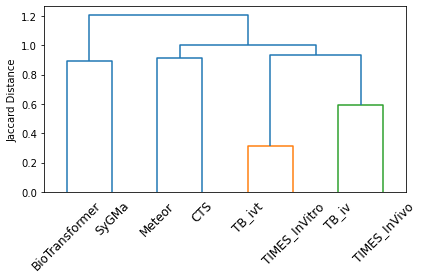

In [78]:
model_dist_vector = pdist(model_fingerprint_DF, 'jaccard')

cluster = hc.linkage(model_dist_vector, method = 'ward')
plot = hc.dendrogram(cluster, labels = ['TB_iv', 'TB_ivt', 'Meteor','BioTransformer','TIMES_InVivo','TIMES_InVitro','SyGMa', 'CTS'], leaf_rotation = 45)
plt.ylabel('Jaccard Distance')

plt.tight_layout()
plt.savefig(figures_dir+'similarity_hcluster_031221.png', transparent = True)

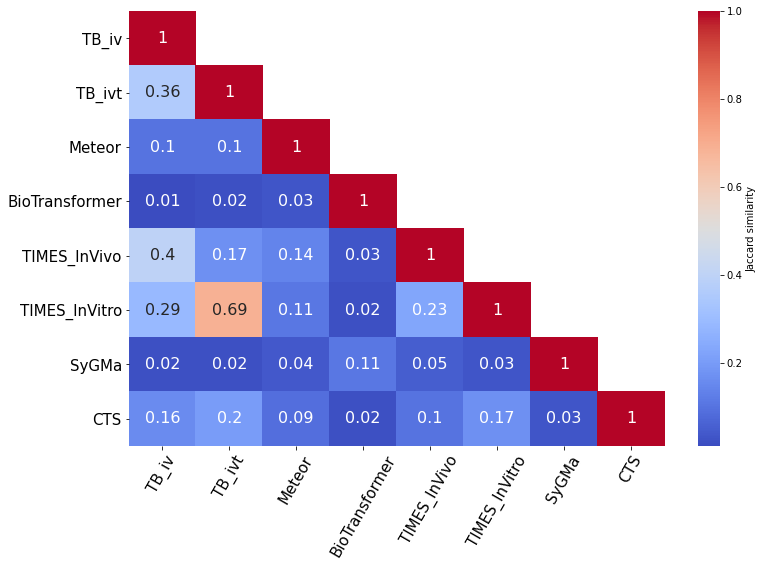

In [79]:
D_met = pd.DataFrame(squareform(model_dist_vector), columns = model_fingerprint_DF.index, index = model_fingerprint_DF.index)
S_met = 1-D_met.where(np.tril(np.ones(D_met.shape)).astype(np.bool))

plt.figure(figsize=(12, 8))
sns.heatmap(S_met.round(2), cmap = 'coolwarm',annot=True, cbar_kws={'label': 'Jaccard similarity'}, annot_kws={"size": 16})
plt.yticks(fontsize = 15)
plt.xticks(fontsize = 15, rotation = 60)
plt.savefig(figures_dir+'Similarity_mx_031221.png', bbox_inches='tight');

### Coverage of predictions between each model pairing and empirical statistics (precision and sensitivity)

In [80]:
# Generate a dataframe that compares the coverage of metabolites between the prediction software and the reported metabolites
#   To generate the table, the software columns are taken from the the aggreagate dataframe and the total and unique
#   metabolites are generated.

matchCompare = agg_Data[modelList].copy()
#Creates a sum across columns to record sum of presence of a specific metabolite across the diiferent tools
matchCompare['Match_Count']= matchCompare.apply(lambda x: sum(x), axis = 1)

model_Comp_RawCount = pd.DataFrame(data = None, columns=['Model','Total','Unique'] + modelList)
#First column is just the list of software tools/reported
model_Comp_RawCount.loc[:,'Model'] = [model for model in modelList]
#Second column is a sum of all the metabolites counted per software tool/reported
model_Comp_RawCount.loc[:,'Total'] = [totalCount for totalCount in matchCompare[modelList].sum(axis=0)]

uniqueCounts = [matchCompare[match][(matchCompare[match]==1.0)&(matchCompare['Match_Count']==1.0)].sum() for match in modelList]
model_Comp_RawCount.loc[:,'Unique'] = uniqueCounts

#Find matching predictions between two models
for model in modelList:
    model_Comp_RawCount.loc[:,model] = [(matchCompare[model][(matchCompare[model]==1.0)&(matchCompare[match] == 1.0)].sum()) for match in modelList]
    
#Calculate performance metrics
model_Comp_RawCount['Precision'] = [calcPrecision(agg_Data, x) for x in modelList]
model_Comp_RawCount['Sensitivity'] = [calcSensitivity(agg_Data, x) for x in modelList]
    
model_Comp_RawCount

,Model,Total,Unique,TB_ivt,TB_iv,Meteor,BioTransformer,TIMES_InVivo,TIMES_InVitro,SyGMa,CTS,Reported,Precision,Sensitivity
0,TB_ivt,194.0,0.0,194.0,113.0,80.0,62.0,113.0,194.0,107.0,109.0,56.0,0.289,0.219
1,TB_iv,236.0,4.0,113.0,236.0,90.0,46.0,232.0,117.0,108.0,99.0,57.0,0.242,0.227
2,Meteor,714.0,414.0,80.0,90.0,714.0,102.0,153.0,98.0,240.0,94.0,67.0,0.094,0.231
3,BioTransformer,3464.0,2553.0,62.0,46.0,102.0,3464.0,114.0,84.0,840.0,82.0,39.0,0.011,0.147
4,TIMES_InVivo,570.0,120.0,113.0,232.0,153.0,114.0,570.0,158.0,295.0,99.0,70.0,0.123,0.279
5,TIMES_InVitro,283.0,20.0,194.0,117.0,98.0,84.0,158.0,283.0,162.0,109.0,65.0,0.230,0.255
6,SyGMa,5215.0,4018.0,107.0,108.0,240.0,840.0,295.0,162.0,5215.0,153.0,73.0,0.014,0.283
7,CTS,472.0,254.0,109.0,99.0,94.0,82.0,99.0,109.0,153.0,472.0,46.0,0.097,0.179
8,Reported,822.0,708.0,56.0,57.0,67.0,39.0,70.0,65.0,73.0,46.0,822.0,1.000,1.000


In [82]:
np.count_nonzero((matchCompare['TB_ivt']==1.0)&(matchCompare['Meteor'] == 1.0))

80

In [83]:
model_Comp_RawCount.to_csv(interim_dat_dir+'Model_Comp_RawCount_0312821.csv')

In [84]:
#Convert the model columns from total overlapping counts to %coverage between each model.
#% coverage takes the total overlapping predictions for Model1 and Model2 divided by the total predictions of Model2. The resulting value states that Model1
# covers x% of the predictions generated by Model2. In this caluclating, Model1 are the models in Column 1 and Model2 are the models between Columns 4-8
# (e.g., metabolites generated by Meteor (Col 1, Row 2) cover ~38.96% of the metabolites generated by ToolBox, ~6.78% of the metabolites generated by 
# BioTransformer, ~25.75% of the metabolites from TIMES_InVivo, and ~37.55% of metabolites generated by TIMES_InVitro)

model_Comp_Percent = model_Comp_RawCount.copy()

for model in modelList:
    model_Comp_Percent.loc[:,model] = [round((matchCompare[model][(matchCompare[model]==1.0)&(matchCompare[match] == 1.0)].sum()*100/model_Comp_Percent['Total'][modelList.index(model)]),2) for match in modelList]

avg_coverage = [round((model_Comp_Percent.loc[x,modelList].sum()-100)/(len(modelList)-1),2) for x in range(model_Comp_Percent.shape[0])]
model_Comp_Percent['Avg. Coverage'] = avg_coverage


model_Comp_Percent

,Model,Total,Unique,TB_ivt,TB_iv,Meteor,BioTransformer,TIMES_InVivo,TIMES_InVitro,SyGMa,CTS,Reported,Precision,Sensitivity,Avg. Coverage
0,TB_ivt,194.0,0.0,100.00,47.88,11.20,1.79,19.82,68.55,2.05,23.09,6.81,0.289,0.219,22.65
1,TB_iv,236.0,4.0,58.25,100.00,12.61,1.33,40.70,41.34,2.07,20.97,6.93,0.242,0.227,23.03
2,Meteor,714.0,414.0,41.24,38.14,100.00,2.94,26.84,34.63,4.60,19.92,8.15,0.094,0.231,22.06
3,BioTransformer,3464.0,2553.0,31.96,19.49,14.29,100.00,20.00,29.68,16.11,17.37,4.74,0.011,0.147,19.21
4,TIMES_InVivo,570.0,120.0,58.25,98.31,21.43,3.29,100.00,55.83,5.66,20.97,8.52,0.123,0.279,34.03
5,TIMES_InVitro,283.0,20.0,100.00,49.58,13.73,2.42,27.72,100.00,3.11,23.09,7.91,0.230,0.255,28.44
6,SyGMa,5215.0,4018.0,55.15,45.76,33.61,24.25,51.75,57.24,100.00,32.42,8.88,0.014,0.283,38.63
7,CTS,472.0,254.0,56.19,41.95,13.17,2.37,17.37,38.52,2.93,100.00,5.60,0.097,0.179,22.26
8,Reported,822.0,708.0,28.87,24.15,9.38,1.13,12.28,22.97,1.40,9.75,100.00,1.000,1.000,13.74


In [89]:
5215/9539

0.5467030087011218

In [85]:
model_Comp_Percent.to_csv(interim_dat_dir+'Model_Comp_Percent_031221.csv')

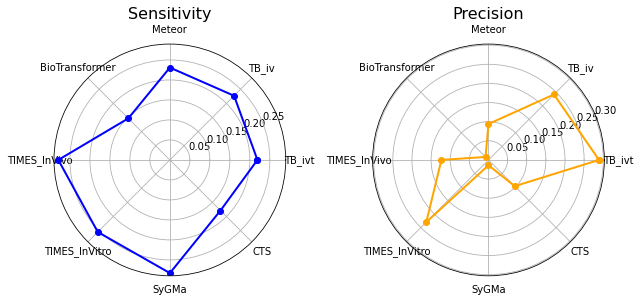

In [86]:
labels=np.array(modelList[:-1])
angles=np.linspace(0, 2*np.pi, len(labels), endpoint=False)
angles=np.concatenate((angles,[angles[0]]))

precision = model_Comp_RawCount.Precision[:-1]
precisionForPlot = np.concatenate((precision,[precision[0]]))

sensitivity = model_Comp_RawCount.Sensitivity[:-1]
sensitivityForPlot = np.concatenate((sensitivity,[sensitivity[0]]))

fig = plt.figure(figsize = (9, 15))

ax1 = fig.add_subplot(121, polar=True)
ax1.set_title('Sensitivity', fontsize = 16)
ax1.set_thetagrids(angles[:-1] * 180/np.pi, labels)
sensitivityPlot =  ax1.plot(angles, sensitivityForPlot, 'o-', linewidth=2, color = 'blue')

ax2 = fig.add_subplot(122, polar=True)
ax2.set_title('Precision', fontsize = 16)
ax2.set_thetagrids(angles[:-1] * 180/np.pi, labels)
precisionPlot =  ax2.plot(angles, precisionForPlot, 'o-', linewidth=2, color = 'orange')

plt.tight_layout()

### Generalized Ranking: Average between Precision and Sensitivity

In [87]:
rankingDF = model_Comp_Percent[['Model','Precision', 'Sensitivity']].copy()
rankingDF['Average'] = rankingDF[['Precision', 'Sensitivity']].mean(axis = 1)
rankingDF

,Model,Precision,Sensitivity,Average
0,TB_ivt,0.289,0.219,0.2540
1,TB_iv,0.242,0.227,0.2345
2,Meteor,0.094,0.231,0.1625
3,BioTransformer,0.011,0.147,0.0790
4,TIMES_InVivo,0.123,0.279,0.2010
5,TIMES_InVitro,0.230,0.255,0.2425
6,SyGMa,0.014,0.283,0.1485
7,CTS,0.097,0.179,0.1380
8,Reported,1.000,1.000,1.0000
